In [1]:
import research_kit_bottom_trend_follow as rk
rk.pd.set_option("display.max_columns", 250)
rk.pd.set_option("display.max_rows", 250)
import warnings
warnings.filterwarnings('ignore')

tradingbot = rk.BottomTrendFollow(db_client=rk.mysql_client, exchange_client=rk.bitmex_exchange_client, is_backtest=True)

classification_train_start_time = rk.datetime(2019,9,1,0,0)
classification_train_end_time = rk.datetime(2020,12,24,0,0)

downloading BTC/USD data on bitmex
downloading 2020-01-06 22:52:30 ~ 2020-01-07 07:12:30 data
50.0% completed
downloading 2020-01-07 07:12:30 ~ 2020-01-07 10:24:44.966258 data
100.0% completed
Loading OHLCV data from bitmex_original_ohlcv_1min now...


まず分析と分類だ
あるidのtransaction logにwin loseのフラグがついているので、これをohlcvからentry timeに対して結合させる
9/1~11/30をtrain、それ以降から12/25までをテストとする
その成績で使うメソッドを考える。

12/15以降が前者2つと比較してパフォーマンスを比較する期間である。

In [4]:
#id_1_inv = rk.generate_transaction_log_by_param(tradingbot=tradingbot, timeframe_param=30, 
#    backtest_start_time=classification_train_start_time,
#    backtest_end_time=classification_train_end_time,
#    bottom_trend_tick=5, middle_trend_tick=3, top_trend_tick=1, inverse_trading=True,
#    random_forest_leverage_adjust=False, close_position_on_do_nothing=True)
id_1_inv = 4496

In [5]:
ohlcv_df_1min = rk.dataset_manager.get_ohlcv(start_time=classification_train_start_time, end_time=classification_train_end_time)
print(ohlcv_df_1min.head())
params_df, summary_df, transaction_log_df = rk.get_params_summary_log_df_by_summary_id(id_1_inv)

Loading OHLCV data from bitmex_original_ohlcv_1min now...
                              ad asset_name      atr   close exchange_name  \
timestamp                                                                    
2019-09-01 01:00:00 -148448000.0    BTC/USD  2.12953  9598.5        bitmex   
2019-09-01 01:01:00 -148005000.0    BTC/USD  2.12028  9599.5        bitmex   
2019-09-01 01:02:00 -147959000.0    BTC/USD  2.00454  9600.0        bitmex   
2019-09-01 01:03:00 -148016000.0    BTC/USD  1.89708  9599.5        bitmex   
2019-09-01 01:04:00 -147845000.0    BTC/USD  1.79729  9600.0        bitmex   

                       high     id     low           obv    open     psar  \
timestamp                                                                   
2019-09-01 01:00:00  9600.0  31795  9598.0 -1.877270e+09  9599.5  9590.90   
2019-09-01 01:01:00  9600.0  31796  9598.0 -1.876380e+09  9598.5  9591.09   
2019-09-01 01:02:00  9600.0  31797  9599.5 -1.876340e+09  9599.5  9591.28   
2019-09-01

In [7]:
merged_df = rk.pd.merge(transaction_log_df, ohlcv_df_1min, left_on="entry_time", right_on=ohlcv_df_1min.index)
print(merged_df.head())
#win_transaction_log = transaction_log_df[transaction_log_df.profit_status == "win"]
#lose_transaction_log = transaction_log_df[transaction_log_df.profit_status == "lose"]

#win_merged_open  = rk.pd.merge(win_transaction_log, ohlcv_df_1min, left_on="entry_time", right_on=ohlcv_df_1min.index)
#lose_merged_open = rk.pd.merge(lose_transaction_log, ohlcv_df_1min, left_on="entry_time", right_on=ohlcv_df_1min.index)

#win_merged_test   = win_merged_open[(win_merged_open.entry_time > rk.datetime(2019,12,12,0,0)) & (
#    win_merged_open.close_time <= rk.datetime(2019,12,24,0,0))]
#win_merged_train  = win_merged_open[win_merged_open.entry_time <= rk.datetime(2019,12,12,0,0)]

#lose_merged_test  = lose_merged_open[(lose_merged_open.entry_time > rk.datetime(2019,12,12,0,0)) & (
#    lose_merged_open.close_time <= rk.datetime(2019,12,24,0,0))]
#lose_merged_train = lose_merged_open[lose_merged_open.close_time <= rk.datetime(2019,12,12,0,0)] # until 12/24

  asset_name_x  backtest_summary_id  close_price          close_time  \
0      BTC/USD                 4496       9579.0 2019-09-01 04:00:00   
1      BTC/USD                 4496       9624.5 2019-09-01 07:00:00   
2      BTC/USD                 4496       9592.5 2019-09-01 08:00:00   
3      BTC/USD                 4496       9620.0 2019-09-01 09:00:00   
4      BTC/USD                 4496       9624.5 2019-09-01 10:00:00   

   current_balance  entry_price          entry_time exchange_name_x      id_x  \
0          113.850       9565.0 2019-09-01 03:30:00          bitmex  27026478   
1          126.179       9637.0 2019-09-01 06:30:00          bitmex  27026479   
2          148.490       9615.0 2019-09-01 07:30:00          bitmex  27026480   
3          146.767       9618.5 2019-09-01 08:30:00          bitmex  27026481   
4          150.547       9628.5 2019-09-01 09:30:00          bitmex  27026482   

   leverage  lot order_status order_type  price_difference  \
0       1.0  1.0  

In [8]:
# data preprocessing

test_df = merged_df[(merged_df.entry_time > rk.datetime(2019,12,12,0,0)) & (merged_df.close_time <= rk.datetime(2019,12,24,0,0))]
train_df = merged_df[merged_df.entry_time <= rk.datetime(2019,12,12,0,0)]

#x_test  = x[(x.entry_time > rk.datetime(2019,12,12,0,0)) & (x.close_time <= rk.datetime(2019,12,24,0,0))]
#x_train = x[x.entry_time <= rk.datetime(2019,12,12,0,0)]
#y_test  = y[(y.entry_time > rk.datetime(2019,12,12,0,0)) & (y.close_time <= rk.datetime(2019,12,24,0,0))]
#y_train = y[y.entry_time <= rk.datetime(2019,12,12,0,0)]

#x_test.drop(columns=["entry_time", "close_time"])
#x_train.drop(columns=["entry_time", "close_time"])
#y_test.drop(columns=["entry_time", "close_time"])
#y_train.drop(columns=["entry_time", "close_time"])

In [9]:
x_test = test_df[["ad", "atr", "obv", "psar", "roc", "rsi", "slowd", "slowk", "volume", "williams_r"]]
y_test = test_df["profit_status"]
x_train = train_df[["ad", "atr", "obv", "psar", "roc", "rsi", "slowd", "slowk", "volume", "williams_r"]]
y_train = train_df["profit_status"]

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

In [14]:
logistic = LogisticRegression()
logistic.fit(x_train, y_train)
print("logistic train score")
print(logistic.score(x_train, y_train))
print("logistic test score")
print(logistic.score(x_test, y_test))
print(metrics.confusion_matrix(y_test, logistic.predict(x_test)))
print(logistic.predict(x_test.head(1))[0])
print(y_test.tail(1))

logistic train score
0.6114478114478115
logistic test score
0.75
[[111  15]
 [ 26  12]]
lose
1648    win
Name: profit_status, dtype: object


In [100]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(x_train, y_train)
print("knn train score")
print(knn.score(x_train, y_train))
print("knn test score")
print(knn.score(x_test, y_test))
print(metrics.confusion_matrix(y_test, knn.predict(x_test)))

knn train score
0.773063973063973
knn test score
0.7621951219512195
[[125   1]
 [ 38   0]]


In [41]:
svc = SVC()
svc.fit(x_train, y_train)
print("svc train score")
print(svc.score(x_train, y_train))
print("svc test score")
print(svc.score(x_test, y_test))

svc train score
1.0
svc test score
0.23170731707317074


In [42]:
random_forest = RandomForestClassifier()
random_forest.fit(x_train, y_train)
print("random forest train score")
print(random_forest.score(x_train, y_train))
print("random forest test score")
print(random_forest.score(x_test, y_test))

random forest train score
0.9851851851851852
random forest test score
0.676829268292683


In [48]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping

In [55]:
y_test_dummy = rk.pd.get_dummies(y_test, drop_first=True)
y_train_dummy = rk.pd.get_dummies(y_train, drop_first=True)

In [56]:
logistic_deep_model = Sequential()
logistic_deep_model.add(Dense(1, input_dim=10, kernel_initializer='uniform'))
logistic_deep_model.add(Activation('sigmoid'))
logistic_deep_model.compile(optimizer='adam', loss='binary_crossentropy',
                  metrics=['accuracy'])

In [61]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
hist = logistic_deep_model.fit(x_train, y_train_dummy,
                 epochs=1000, verbose=1,
                 validation_split=0.1,
                 callbacks=[early_stopping])
                 #validation_data=(x_test, y_test_dummy),
                 

Train on 1336 samples, validate on 149 samples
Epoch 1/1000
1336/1336 [==============================] - 0s 94us/step - loss: 162697.6392 - accuracy: 0.5142 - val_loss: 92835.0053 - val_accuracy: 0.3624
Epoch 2/1000
1336/1336 [==============================] - 0s 95us/step - loss: 175712.2737 - accuracy: 0.5165 - val_loss: 545891.1130 - val_accuracy: 0.6376
Epoch 3/1000
1336/1336 [==============================] - 0s 101us/step - loss: 264806.1632 - accuracy: 0.4850 - val_loss: 125858.6927 - val_accuracy: 0.6443


ValueError: x and y must have same first dimension, but have shapes (903,) and (3,)

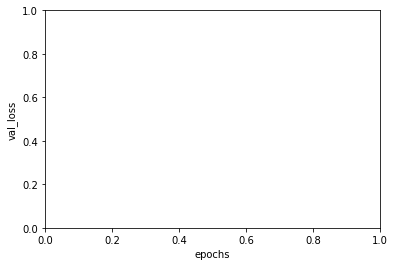

In [62]:
rk.plt.clf()
rk.plt.xlabel('epochs')
rk.plt.ylabel('val_loss')
rk.plt.plot(rk.np.arange(0, 903), hist.history['loss'], label='loss')
rk.plt.plot(rk.np.arange(0, 903), hist.history['val_loss'], label='val_loss')

#logistic_deep_mode.evaluate(x_test, y_test)